In [72]:
import pandas as pd
import numpy as np
import torch
import re
import string

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline

from sentence_transformers import SentenceTransformer
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
import contractions

from bertopic.representation import MaximalMarginalRelevance

os.environ["OMP_DYNAMIC"] = "false"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["KMP_WARNINGS"] = "FALSE"

# 1. Data Overview

This section contains a brief overview of the responses, their distribution, and a sentiment analysis for the provided data.

In [73]:
df = pd.read_csv('cleaned_data.csv')
df.head()

,month_of_action_date,career,score_reason,additional_comment,cleaned_text
0,2024-08-01,parent,Resource Quality,Such fabulous resources. Just not using as des...,such fabulous resources just not using as desi...
1,2024-08-01,ey,Price,I was charged $9 for monthly renewal on 8/10. ...,i was charged 9 for monthly renewal on 810 the...
2,2024-08-01,ks3,Price,most of the resources I found were more for el...,most of the resources i found were more for el...
3,2024-08-01,US Grade 1,Price,It made me laugh that the bot couldn't underst...,it made me laugh that the bot couldnt understa...
4,2024-08-01,US Grade 5,Price,I will be back! Our school had to cut our clas...,i will be back our school had to cut our class...


In [74]:
groupedby_career_reason = df.groupby(['career','score_reason']).size().reset_index(name='count')

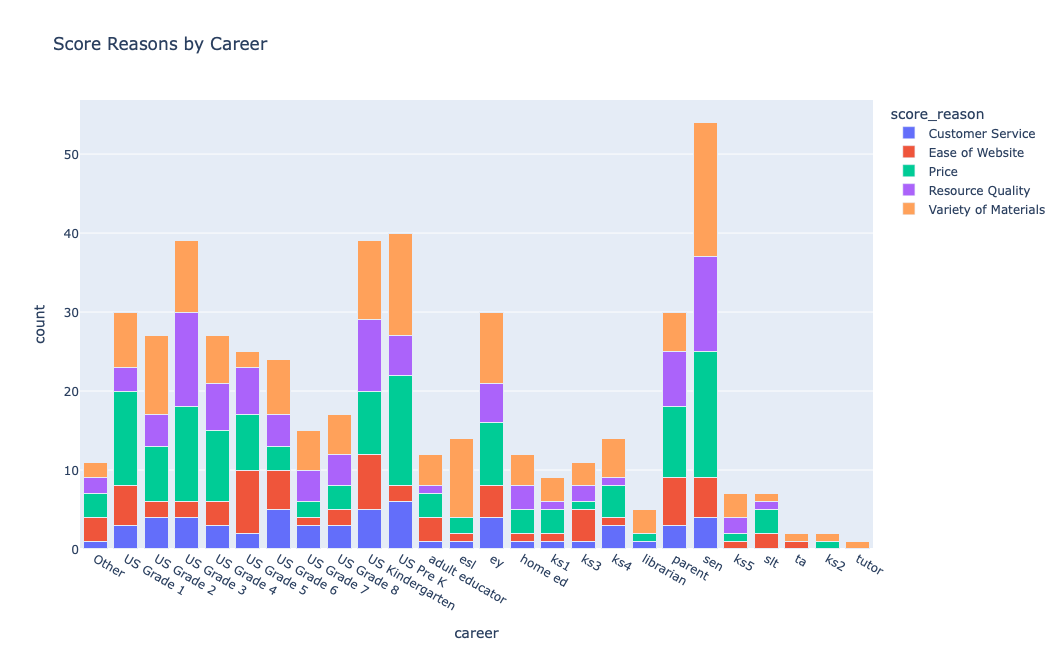

In [75]:
stacked_response_profiles = px.bar(
    groupedby_career_reason,
    x="career",
    y= 'count',
    color="score_reason",
    title="Score Reasons by Career",
    barmode="stack")

stacked_response_profiles.update_layout(
    height=650,
    )

# Show the chart
stacked_response_profiles.show()

In [76]:
from textblob import TextBlob

def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def label_sentiment(score, threshold=0.2):
    if score > threshold:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [77]:
df['sentiment_score'] = df['additional_comment'].apply(analyze_sentiment)

df['sentiment'] = df['sentiment_score'].apply(label_sentiment)

In [78]:
groupedby_career_sentiment = df.groupby(['career', 'sentiment']).size().reset_index(name='count')

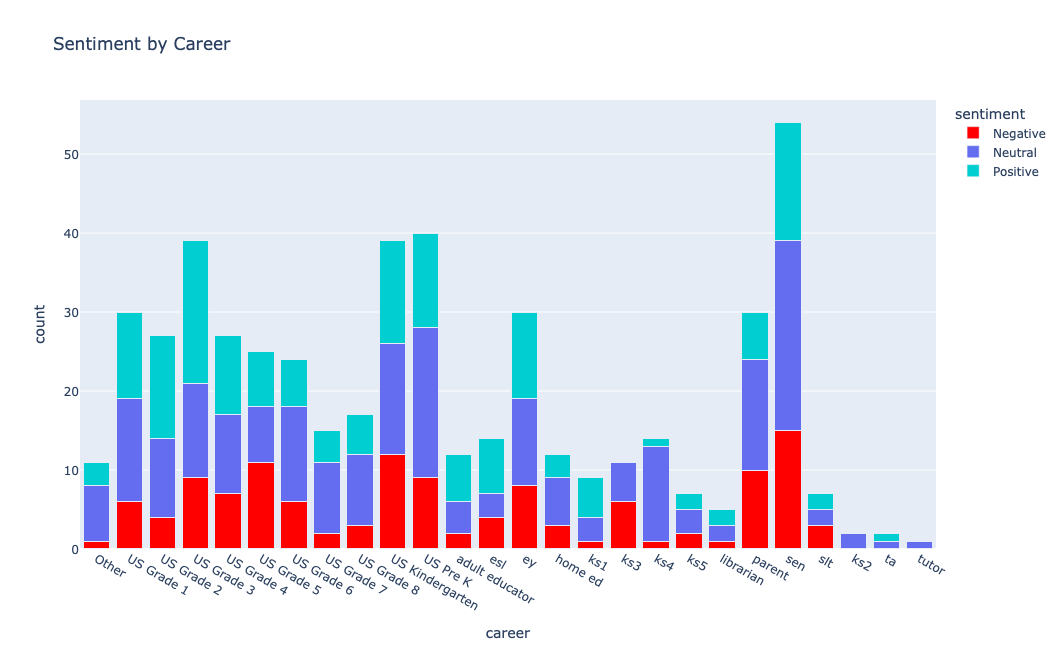

In [79]:
stacked_sentiment = px.bar(
    groupedby_career_sentiment,
    x="career",
    y= 'count',
    color="sentiment",
    color_discrete_map={'Positive':'darkturquoise', 'Neutral':'#646DEF', 'Negative':'red'},
    title="Sentiment by Career",
    barmode="stack")

stacked_sentiment.update_layout(
    height=650,
    )

# Show the chart
stacked_sentiment.show()

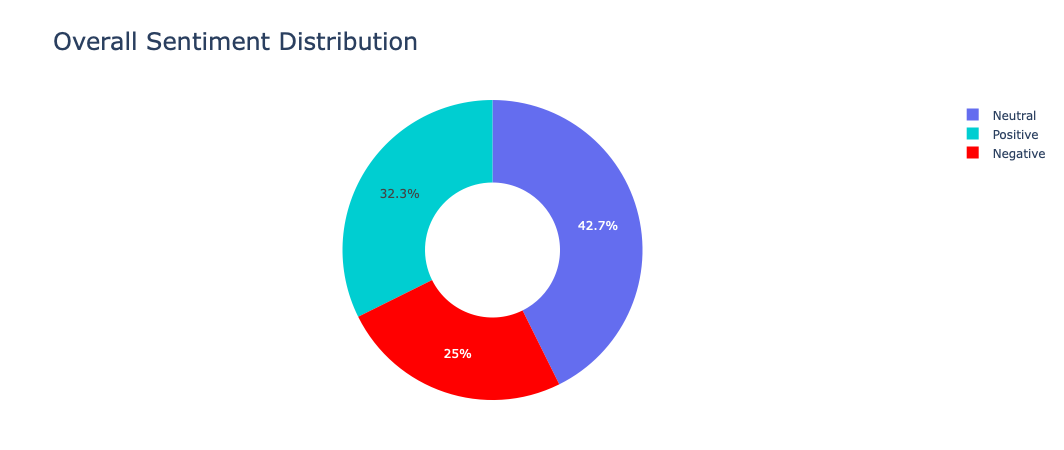

In [80]:
sentiment_pie = px.pie(
    df, 
    names='sentiment',
    color='sentiment',
    color_discrete_map={'Positive':'darkturquoise', 'Neutral':'#646DEF', 'Negative':'red'},
    hole=0.45,
    title="Overall Sentiment Distribution"
)

sentiment_pie.update_traces(hovertemplate='%{label}<extra></extra>')

sentiment_pie.update_layout(
    height=450,
    title_font=dict(size=24),
    margin=dict(t=100, b=50, l=50, r=50),
)

sentiment_pie.show()

# 2. Topic Modeling

In this section we'll conduct topic modeling using BERTopic. Please note that due to the relatively small size of the dataset provided, the granularity of the topics may be rather broad.

We have experimented with multiple ML techniques to obtian the most diverse range of topics without impacting their internal coherence.



## 2.1 Content-Related Answers

Fir this section we have conducted topic modeling only for answers in the _Resource Quality_ and _Variety of Materials_ categories.

In [81]:
from bertopic import BERTopic

topic_model = BERTopic.load("bertopic_model")

In [82]:
def intertopicDistanceMap(topic_model, color="orangered"):
    itdm_chart = topic_model.visualize_topics(
            title="Intertopic Distance Map")
    
    for trace in itdm_chart.data:
        trace.marker.color = color
        trace.marker.line.width = 0
   
    return itdm_chart

In [83]:
itdm_chart = intertopicDistanceMap(topic_model)

itdm_chart.show()

### Description

The **Intertopic Distance Map** chart shows you how close or _related_ any two optics are. The size of each bubble tells you the prominence of that topic across the entire data set. Bigger bubbles represent a higher occurrence frequency.

In [84]:
topics_over_time = pd.read_csv("topics_over_time.csv")

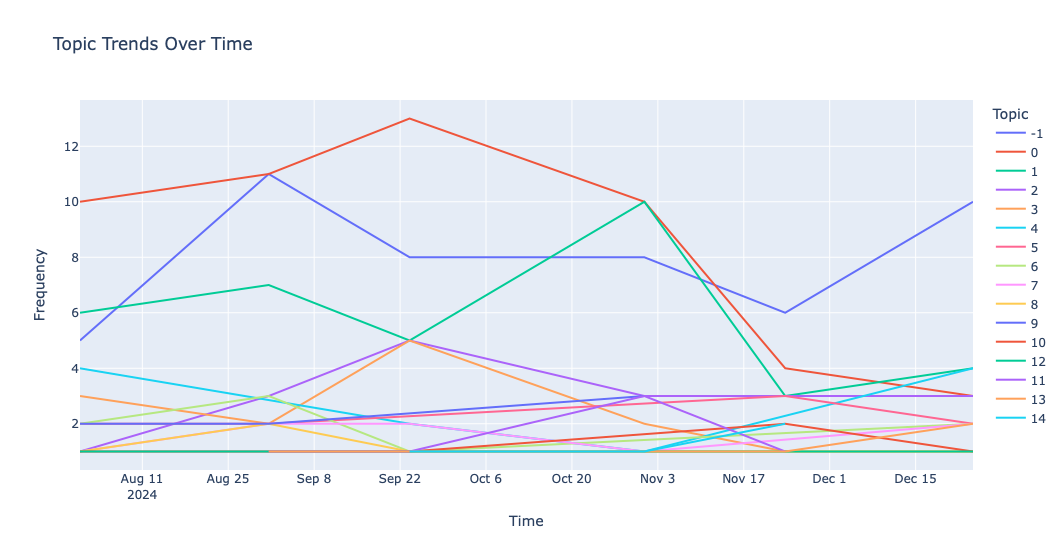

In [85]:
import plotly.express as px

# Convert Timestamp to datetime (if needed)
topics_over_time["Timestamp"] = pd.to_datetime(topics_over_time["Timestamp"])

# Plot topic trends
fig = px.line(
    topics_over_time,
    x="Timestamp",
    y="Frequency",
    color="Topic",
    hover_data={"Words": True},
    title="Topic Trends Over Time"
)

# Customize layout
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Frequency",
    width=950,
    height=550
)

fig.show()

### 2.1.3 Topic KeyWord Distribution

The charts below show the top 8 most common terms for each topic. You may look at these to gain an idea of what each topic represents.

**Make sure you scroll sideways to see all the topics**

**TIP:** Hover over each bar, and it will tell you how stronly that term belongs to that topic.

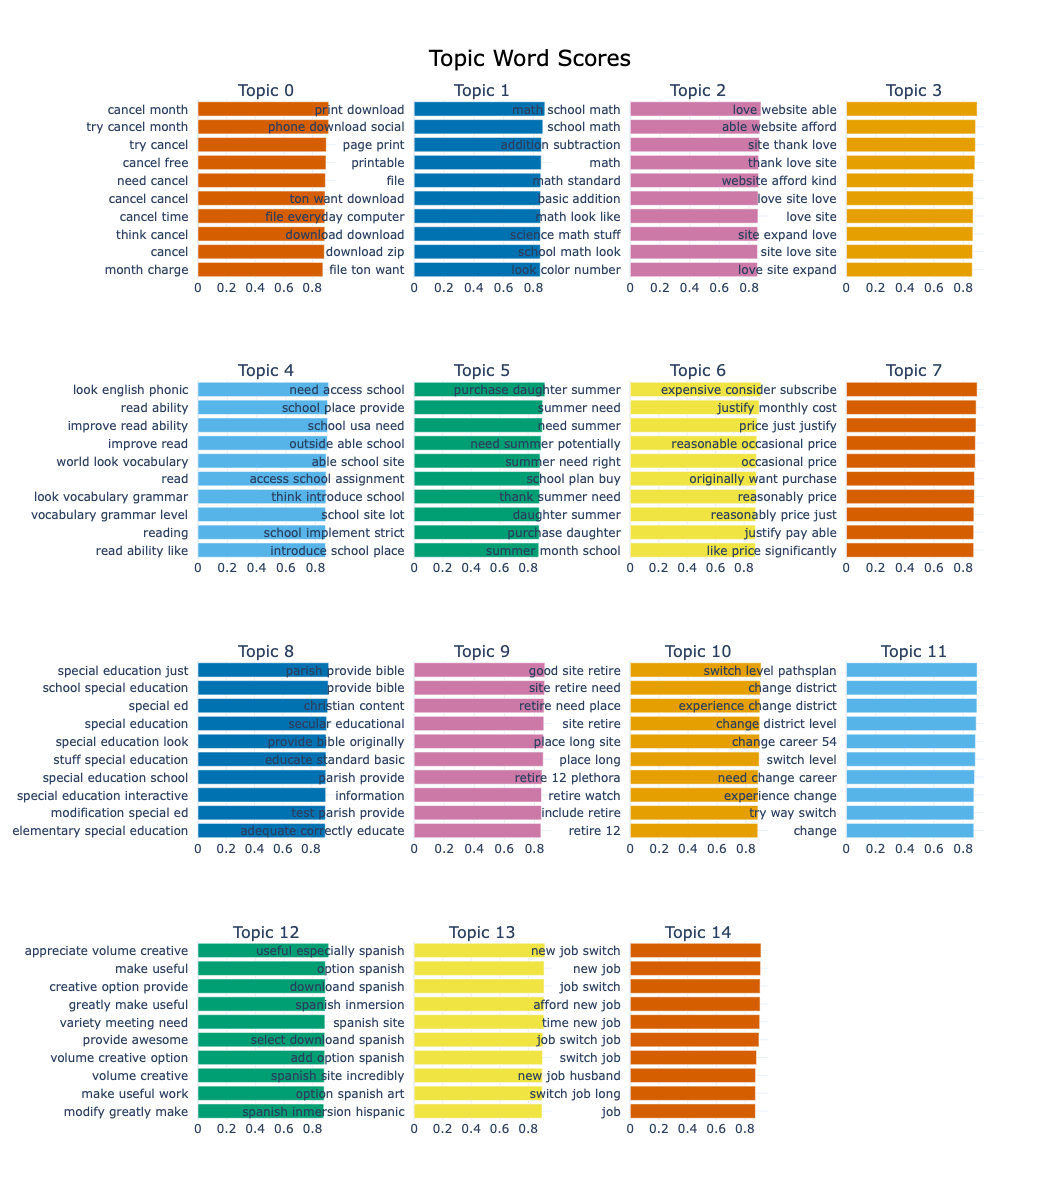

In [86]:
topic_model.visualize_barchart(
    top_n_topics=20,
    n_words=10,
    autoscale=False,
    width=400,
    height=300
)